# MIP Gaussian Splatting Loss Component Ablation Study

This notebook compares 4 trained MIP splatting models with different loss configurations:

1. **WMSE Only**: Weighted MSE loss baseline
2. **WMSE + SSIM**: Adding structural similarity
3. **WMSE + SSIM + Edge**: Adding gradient/edge preservation
4. **WMSE + SSIM + Edge + Intensity**: Full model with intensity sparsity

We evaluate:
- Quantitative metrics (PSNR, SSIM, MAE)
- Training curves and convergence
- Visual quality comparison
- Gaussian count and efficiency

## Setup and Imports

In [41]:
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

# Add src to path
sys.path.insert(0, '/workspace/hisnegs/src/renderer')
from rendering import (
    load_volume, Camera, GaussianParameters,
    render_mip_projection, render_gt_mip,
    compute_aspect_scales, apply_aspect_correction,
    generate_camera_poses, psnr_metric, ssim_loss_fn,
    _orbit_pose
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports complete")

✓ Imports complete


## Configuration

In [42]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Paths
BASE_DIR = Path('/workspace/hisnegs/src/renderer')
CKPT_DIR = BASE_DIR / 'checkpoints'
OUTPUT_DIR = Path('/workspace/hisnegs/ablation_output')
OUTPUT_DIR.mkdir(exist_ok=True)

# Volume path (adjust if needed)
VOL_PATH = '/workspace/hisnegs/dataset/10-2900-control-cell-05_cropped_corrected.tif'

# Model configurations
MODELS = {
    'WMSE': {
        'path': CKPT_DIR / 'checkpoints_wmse' / 'splat_wmse_v2_best.pt',
        'label': 'WMSE + scale_reg',
        'color': '#1f77b4',
        'history': CKPT_DIR / 'checkpoints_wmse' / 'training_history.json'
    },
    'WMSE+SSIM': {
        'path': CKPT_DIR / 'checkpoints_wsme_ssim' / 'splat_wsme_ssim_best.pt',
        'label': 'WMSE + SSIM + scale_reg',
        'color': '#ff7f0e',
        'history': CKPT_DIR / 'checkpoints_wsme_ssim' / 'training_history.json'
    },
    'WMSE+SSIM+Edge': {
        'path': CKPT_DIR / 'train_swme_ssim_edge_checkpoint' / 'splat_swme_ssim_edge_best.pt',
        'label': 'WMSE + SSIM + Edge + scale_reg',
        'color': '#2ca02c',
        'history': CKPT_DIR / 'train_swme_ssim_edge_checkpoint' / 'training_history.json'
    },
    'Full': {
        'path': CKPT_DIR / 'train_swme_ssim_edge_inte_checkpoint' / 'splat_swme_ssim_edge_inte_best.pt',
        'label': 'Full (+ Intensity Sparsity)',
        'color': '#d62728',
        'history': CKPT_DIR / 'train_swme_ssim_edge_inte_checkpoint' / 'training_history.json'
    }
}

print(f"Output directory: {OUTPUT_DIR}")
print(f"Models configured: {len(MODELS)}")
for name, info in MODELS.items():
    exists = "✓" if info['path'].exists() else "✗"
    print(f"  {exists} {name}: {info['label']}")

Device: cuda
Output directory: /workspace/hisnegs/ablation_output
Models configured: 4
  ✓ WMSE: WMSE + scale_reg
  ✓ WMSE+SSIM: WMSE + SSIM + scale_reg
  ✓ WMSE+SSIM+Edge: WMSE + SSIM + Edge + scale_reg
  ✓ Full: Full (+ Intensity Sparsity)


## Load Volume and Setup Camera

In [43]:
# Load volume
print(f"Loading volume: {VOL_PATH}")
vol_np = load_volume(VOL_PATH)
Z, Y, X = vol_np.shape
vol_gpu = torch.from_numpy(vol_np).to(device)

print(f"  Shape (Z,Y,X): ({Z}, {Y}, {X})")
print(f"  Value range: [{vol_np.min():.4f}, {vol_np.max():.4f}]")

# Compute aspect scales
aspect_scales = compute_aspect_scales((Z, Y, X))
print(f"  Aspect scales (x,y,z): {aspect_scales.tolist()}")

# Setup camera
H, W = 1024, 1024
camera = Camera.from_fov(fov_x_deg=50.0, width=W, height=H, near=0.1, far=100.0)
print(f"\nCamera: {W}×{H}, fx={camera.fx:.1f}")

Loading volume: /workspace/hisnegs/dataset/10-2900-control-cell-05_cropped_corrected.tif


  Shape (Z,Y,X): (100, 647, 813)
  Value range: [0.0000, 1.0000]
  Aspect scales (x,y,z): [1.0, 0.7958179712295532, 0.12300123274326324]

Camera: 1024×1024, fx=1098.0


## Helper Functions

In [44]:
def load_checkpoint(ckpt_path, device):
    """Load checkpoint and return Gaussian parameters."""
    ckpt = torch.load(ckpt_path, map_location=device)
    
    means = ckpt['means'].to(device)
    log_scales = ckpt['log_scales'].to(device)
    quaternions = ckpt['quaternions'].to(device)
    log_intensities = ckpt.get('log_intensities', ckpt.get('log_amplitudes')).to(device)
    
    # Build covariances from scales and quaternions
    K = means.shape[0]
    scales = torch.exp(log_scales).clamp(1e-5, 1e2)
    q = F.normalize(quaternions, p=2, dim=-1)
    
    # Quaternion to rotation matrix
    w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
    Rm = torch.zeros(K, 3, 3, device=device, dtype=q.dtype)
    Rm[:, 0, 0] = 1 - 2*(y*y + z*z);  Rm[:, 0, 1] = 2*(x*y - w*z);  Rm[:, 0, 2] = 2*(x*z + w*y)
    Rm[:, 1, 0] = 2*(x*y + w*z);      Rm[:, 1, 1] = 1 - 2*(x*x+z*z);Rm[:, 1, 2] = 2*(y*z - w*x)
    Rm[:, 2, 0] = 2*(x*z - w*y);      Rm[:, 2, 1] = 2*(y*z + w*x);  Rm[:, 2, 2] = 1 - 2*(x*x+y*y)
    
    S2 = torch.diag_embed(scales ** 2)
    cov = Rm @ S2 @ Rm.transpose(-2, -1)
    
    intensities = torch.sigmoid(log_intensities)
    
    gaussians = GaussianParameters(
        means=means,
        covariances=cov,
        intensities=intensities
    )
    
    return gaussians


def evaluate_model(gaussians, camera, vol_gpu, aspect_scales, test_poses, beta=50.0):
    """Evaluate model on test poses."""
    # Apply aspect correction
    gaussians = apply_aspect_correction(gaussians, aspect_scales)
    
    metrics = []
    with torch.no_grad():
        for pose in tqdm(test_poses, desc="Evaluating", leave=False):
            R, T = pose['R'].to(device), pose['T'].to(device)
            
            # Render prediction
            pred_mip, n_vis = render_mip_projection(
                gaussians, camera, R, T, beta=beta, chunk_size=4096
            )
            
            # Render ground truth
            gt_mip = render_gt_mip(
                vol_gpu, camera, R, T,
                n_samples=256, near=0.5, far=6.0,
                aspect_scales=aspect_scales
            )
            
            # Compute metrics
            mse = F.mse_loss(pred_mip, gt_mip).item()
            psnr = -10.0 * np.log10(max(mse, 1e-12))
            ssim = 1.0 - ssim_loss_fn(pred_mip, gt_mip).item()
            mae = F.l1_loss(pred_mip, gt_mip).item()
            
            metrics.append({
                'psnr': psnr,
                'ssim': ssim,
                'mae': mae,
                'mse': mse,
                'n_visible': n_vis
            })
    
    return pd.DataFrame(metrics)

print("✓ Helper functions defined")

✓ Helper functions defined


## Load All Models

In [45]:
# Load all checkpoints
loaded_models = {}

print("Loading model checkpoints...")
for name, info in MODELS.items():
    print(f"\n{name}: {info['label']}")
    gaussians = load_checkpoint(info['path'], device)
    K = gaussians.means.shape[0]
    print(f"  Gaussians: {K:,}")
    print(f"  Intensity range: [{gaussians.intensities.min():.4f}, {gaussians.intensities.max():.4f}]")
    loaded_models[name] = gaussians

print("\n✓ All models loaded")

Loading model checkpoints...

WMSE: WMSE + scale_reg
  Gaussians: 49,484
  Intensity range: [0.0101, 0.9933]

WMSE+SSIM: WMSE + SSIM + scale_reg
  Gaussians: 47,564
  Intensity range: [0.0101, 0.9933]

WMSE+SSIM+Edge: WMSE + SSIM + Edge + scale_reg
  Gaussians: 47,564
  Intensity range: [0.0101, 0.9933]

Full: Full (+ Intensity Sparsity)
  Gaussians: 41,471
  Intensity range: [0.0100, 0.9933]

✓ All models loaded


## Load Training Histories

In [46]:
# Load training history for each model
training_histories = {}

print("Loading training histories...")
for name, info in MODELS.items():
    if info['history'].exists():
        with open(info['history'], 'r') as f:
            history = json.load(f)
        training_histories[name] = pd.DataFrame(history)
        print(f"  {name}: {len(history)} epochs")
    else:
        print(f"  ⚠️  {name}: History not found")

print("✓ Training histories loaded")

Loading training histories...
  WMSE: 2000 epochs
  WMSE+SSIM: 1500 epochs
  WMSE+SSIM+Edge: 2000 epochs
  Full: 2000 epochs
✓ Training histories loaded


## Generate Test Poses

In [47]:
# Generate diverse test views
print("Generating test poses...")
test_poses = generate_camera_poses(
    n_azimuth=8,
    n_elevation=3,
    elevation_range=(-45.0, 45.0),
    radius=3.5,
    include_axis_aligned=True
)

print(f"  Generated {len(test_poses)} test views")
print(f"  Elevation range: {min(p['elevation'] for p in test_poses):.1f}° to {max(p['elevation'] for p in test_poses):.1f}°")
print(f"  Azimuth samples: 8")

Generating test poses...
  Generated 30 test views
  Elevation range: -89.0° to 89.0°
  Azimuth samples: 8


## Evaluate All Models

In [48]:
# Evaluate each model on test poses
evaluation_results = {}

print("Evaluating models on test set...\n")
for name, gaussians in loaded_models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating: {MODELS[name]['label']}")
    print(f"{'='*60}")
    
    metrics_df = evaluate_model(
        gaussians, camera, vol_gpu, aspect_scales, test_poses, beta=50.0
    )
    evaluation_results[name] = metrics_df
    
    # Print summary statistics
    print(f"\nResults (mean ± std):")
    print(f"  PSNR: {metrics_df['psnr'].mean():.2f} ± {metrics_df['psnr'].std():.2f} dB")
    print(f"  SSIM: {metrics_df['ssim'].mean():.4f} ± {metrics_df['ssim'].std():.4f}")
    print(f"  MAE:  {metrics_df['mae'].mean():.5f} ± {metrics_df['mae'].std():.5f}")
    print(f"  Visible Gaussians: {metrics_df['n_visible'].mean():.0f}")

print("\n" + "="*60)
print("✓ Evaluation complete")
print("="*60)

Evaluating models on test set...


Evaluating: WMSE + scale_reg


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Results (mean ± std):
  PSNR: 37.41 ± 1.19 dB
  SSIM: 0.9801 ± 0.0041
  MAE:  0.00310 ± 0.00086
  Visible Gaussians: 49484

Evaluating: WMSE + SSIM + scale_reg


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Results (mean ± std):
  PSNR: 37.97 ± 1.43 dB
  SSIM: 0.9869 ± 0.0030
  MAE:  0.00271 ± 0.00087
  Visible Gaussians: 47564

Evaluating: WMSE + SSIM + Edge + scale_reg


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Results (mean ± std):
  PSNR: 38.14 ± 1.62 dB
  SSIM: 0.9874 ± 0.0032
  MAE:  0.00268 ± 0.00091
  Visible Gaussians: 47564

Evaluating: Full (+ Intensity Sparsity)


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Results (mean ± std):
  PSNR: 38.15 ± 1.45 dB
  SSIM: 0.9875 ± 0.0028
  MAE:  0.00266 ± 0.00085
  Visible Gaussians: 41471

✓ Evaluation complete


## Summary Statistics Table

In [49]:
# Create comprehensive summary table
summary_data = []

for name in MODELS.keys():
    metrics_df = evaluation_results[name]
    gaussians = loaded_models[name]
    
    summary_data.append({
        'Model': MODELS[name]['label'],
        'Gaussians': gaussians.means.shape[0],
        'PSNR (dB)': f"{metrics_df['psnr'].mean():.2f} ± {metrics_df['psnr'].std():.2f}",
        'SSIM': f"{metrics_df['ssim'].mean():.4f} ± {metrics_df['ssim'].std():.4f}",
        'MAE': f"{metrics_df['mae'].mean():.5f} ± {metrics_df['mae'].std():.5f}",
        'MSE': f"{metrics_df['mse'].mean():.6f} ± {metrics_df['mse'].std():.6f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save to CSV
summary_df.to_csv(OUTPUT_DIR / 'ablation_summary.csv', index=False)
print(f"\n✓ Summary saved to {OUTPUT_DIR / 'ablation_summary.csv'}")


ABLATION STUDY SUMMARY
                         Model  Gaussians    PSNR (dB)            SSIM               MAE                 MSE
              WMSE + scale_reg      49484 37.41 ± 1.19 0.9801 ± 0.0041 0.00310 ± 0.00086 0.000188 ± 0.000053
       WMSE + SSIM + scale_reg      47564 37.97 ± 1.43 0.9869 ± 0.0030 0.00271 ± 0.00087 0.000168 ± 0.000056
WMSE + SSIM + Edge + scale_reg      47564 38.14 ± 1.62 0.9874 ± 0.0032 0.00268 ± 0.00091 0.000164 ± 0.000061
   Full (+ Intensity Sparsity)      41471 38.15 ± 1.45 0.9875 ± 0.0028 0.00266 ± 0.00085 0.000161 ± 0.000054

✓ Summary saved to /workspace/hisnegs/ablation_output/ablation_summary.csv


## Visualization: Training Curves Comparison

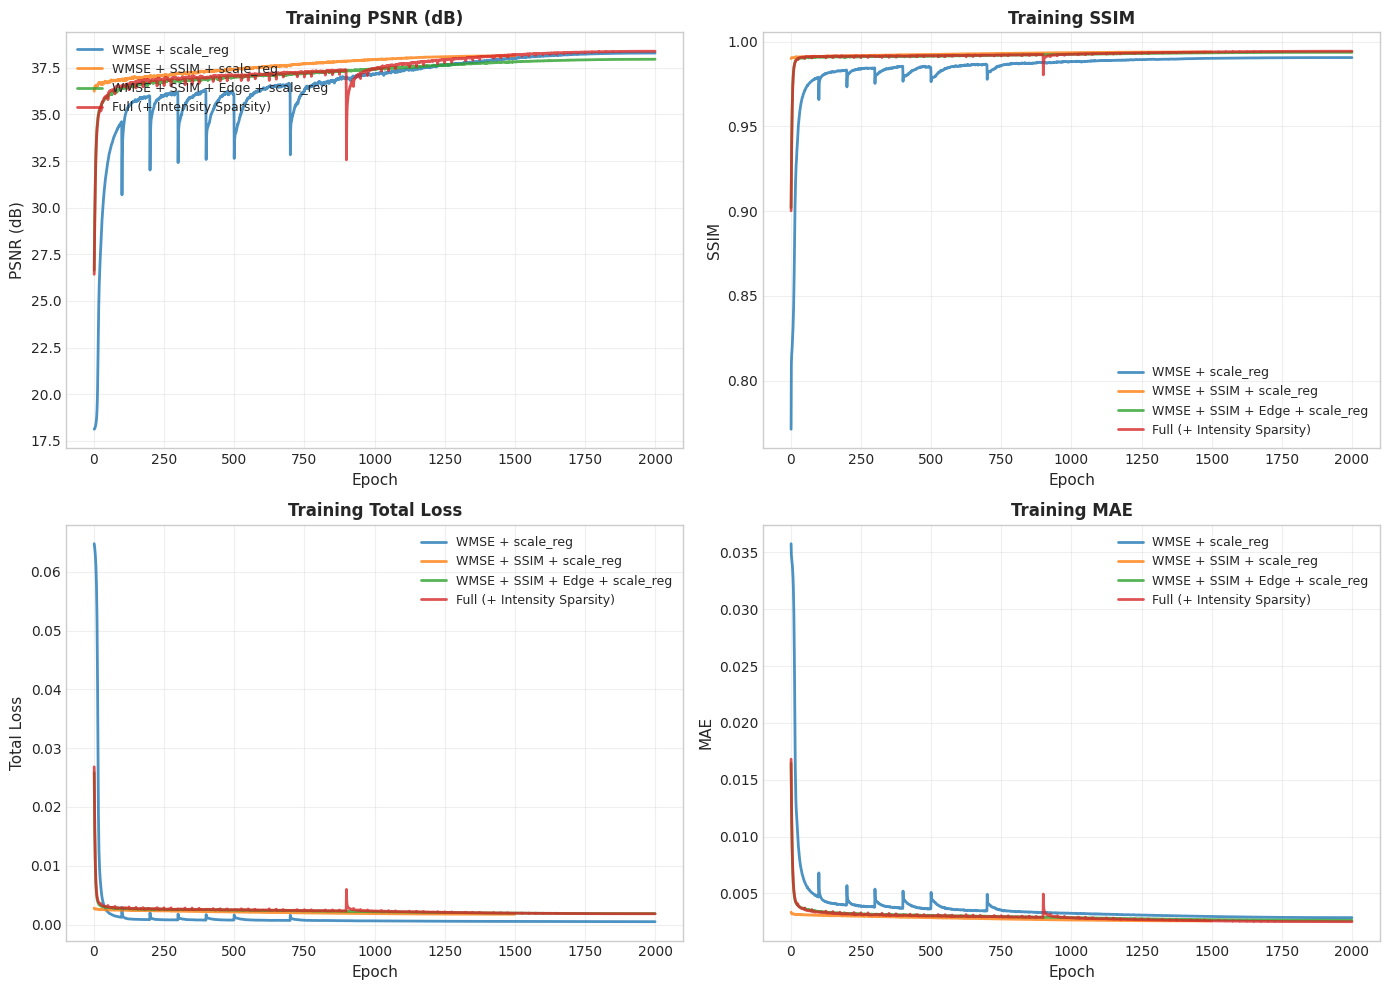

✓ Training curves saved to /workspace/hisnegs/experiments/ablation_training_curves.pdf


In [50]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = [
    ('psnr', 'PSNR (dB)', 'upper left'),
    ('ssim', 'SSIM', 'lower right'),
    ('loss', 'Total Loss', 'upper right'),
    ('mae', 'MAE', 'upper right')
]

for idx, (metric, ylabel, legend_loc) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for name in MODELS.keys():
        if name in training_histories:
            hist = training_histories[name]
            if metric in hist.columns:
                epochs = np.arange(1, len(hist) + 1)
                ax.plot(epochs, hist[metric], 
                       label=MODELS[name]['label'],
                       color=MODELS[name]['color'],
                       linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'Training {ylabel}', fontsize=12, fontweight='bold')
    ax.legend(loc=legend_loc, fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
experiments_dir = Path('/workspace/hisnegs/experiments')
experiments_dir.mkdir(exist_ok=True)
plt.savefig(experiments_dir / 'ablation_training_curves.png', dpi=300, bbox_inches='tight')
plt.savefig(experiments_dir / 'ablation_training_curves.pdf', bbox_inches='tight')

plt.show()
print(f"✓ Training curves saved to {experiments_dir / 'ablation_training_curves.pdf'}")


## Visualization: Metric Distributions

/tmp/ipykernel_105449/1042038491.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
/tmp/ipykernel_105449/1042038491.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
/tmp/ipykernel_105449/1042038491.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, showmeans=True)


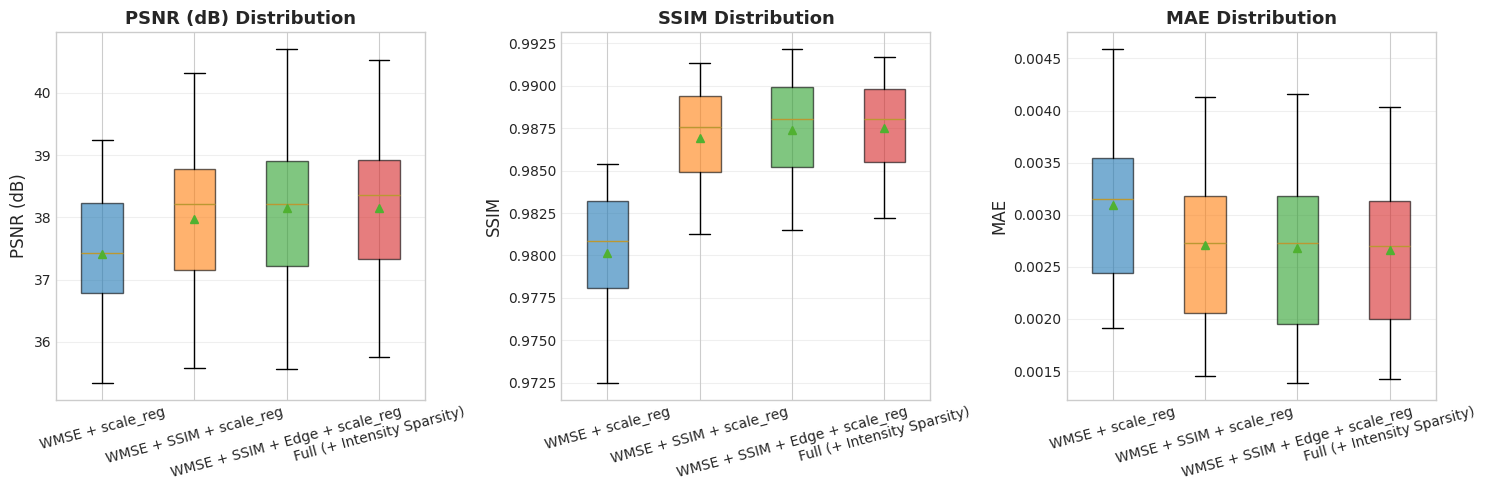

✓ Metric distributions saved to /workspace/hisnegs/experiments/ablation_metric_distributions.pdf


In [51]:
# Box plots comparing metric distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['psnr', 'ssim', 'mae']
titles = ['PSNR (dB)', 'SSIM', 'MAE']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    data = []
    labels = []
    colors = []
    
    for name in MODELS.keys():
        data.append(evaluation_results[name][metric].values)
        labels.append(MODELS[name]['label'])
        colors.append(MODELS[name]['color'])
    
    bp = ax.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} Distribution', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
experiments_dir = Path('/workspace/hisnegs/experiments')
plt.savefig(experiments_dir / 'ablation_metric_distributions.png', dpi=300, bbox_inches='tight')
plt.savefig(experiments_dir / 'ablation_metric_distributions.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Metric distributions saved to {experiments_dir / 'ablation_metric_distributions.pdf'}")

## Visualization: Model Efficiency

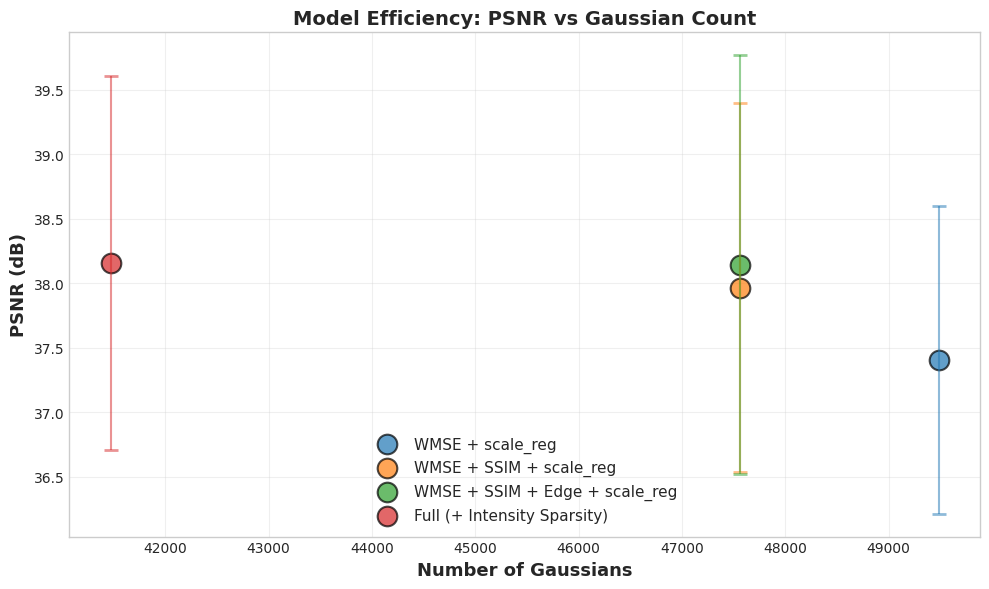

✓ Efficiency plot saved to /workspace/hisnegs/experiments/ablation_efficiency.pdf


In [52]:
# Scatter plot: PSNR vs Gaussian count
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for name in MODELS.keys():
    metrics_df = evaluation_results[name]
    gaussians = loaded_models[name]
    K = gaussians.means.shape[0]
    psnr_mean = metrics_df['psnr'].mean()
    psnr_std = metrics_df['psnr'].std()
    
    ax.scatter(K, psnr_mean, s=200, color=MODELS[name]['color'], 
              label=MODELS[name]['label'], alpha=0.7, edgecolors='black', linewidth=1.5)
    ax.errorbar(K, psnr_mean, yerr=psnr_std, color=MODELS[name]['color'], 
               capsize=5, capthick=2, alpha=0.5)

ax.set_xlabel('Number of Gaussians', fontsize=13, fontweight='bold')
ax.set_ylabel('PSNR (dB)', fontsize=13, fontweight='bold')
ax.set_title('Model Efficiency: PSNR vs Gaussian Count', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
experiments_dir = Path('/workspace/hisnegs/experiments')
plt.savefig(experiments_dir / 'ablation_efficiency.png', dpi=300, bbox_inches='tight')
plt.savefig(experiments_dir / 'ablation_efficiency.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Efficiency plot saved to {experiments_dir / 'ablation_efficiency.pdf'}")

## Visual Comparison: Sample Renderings

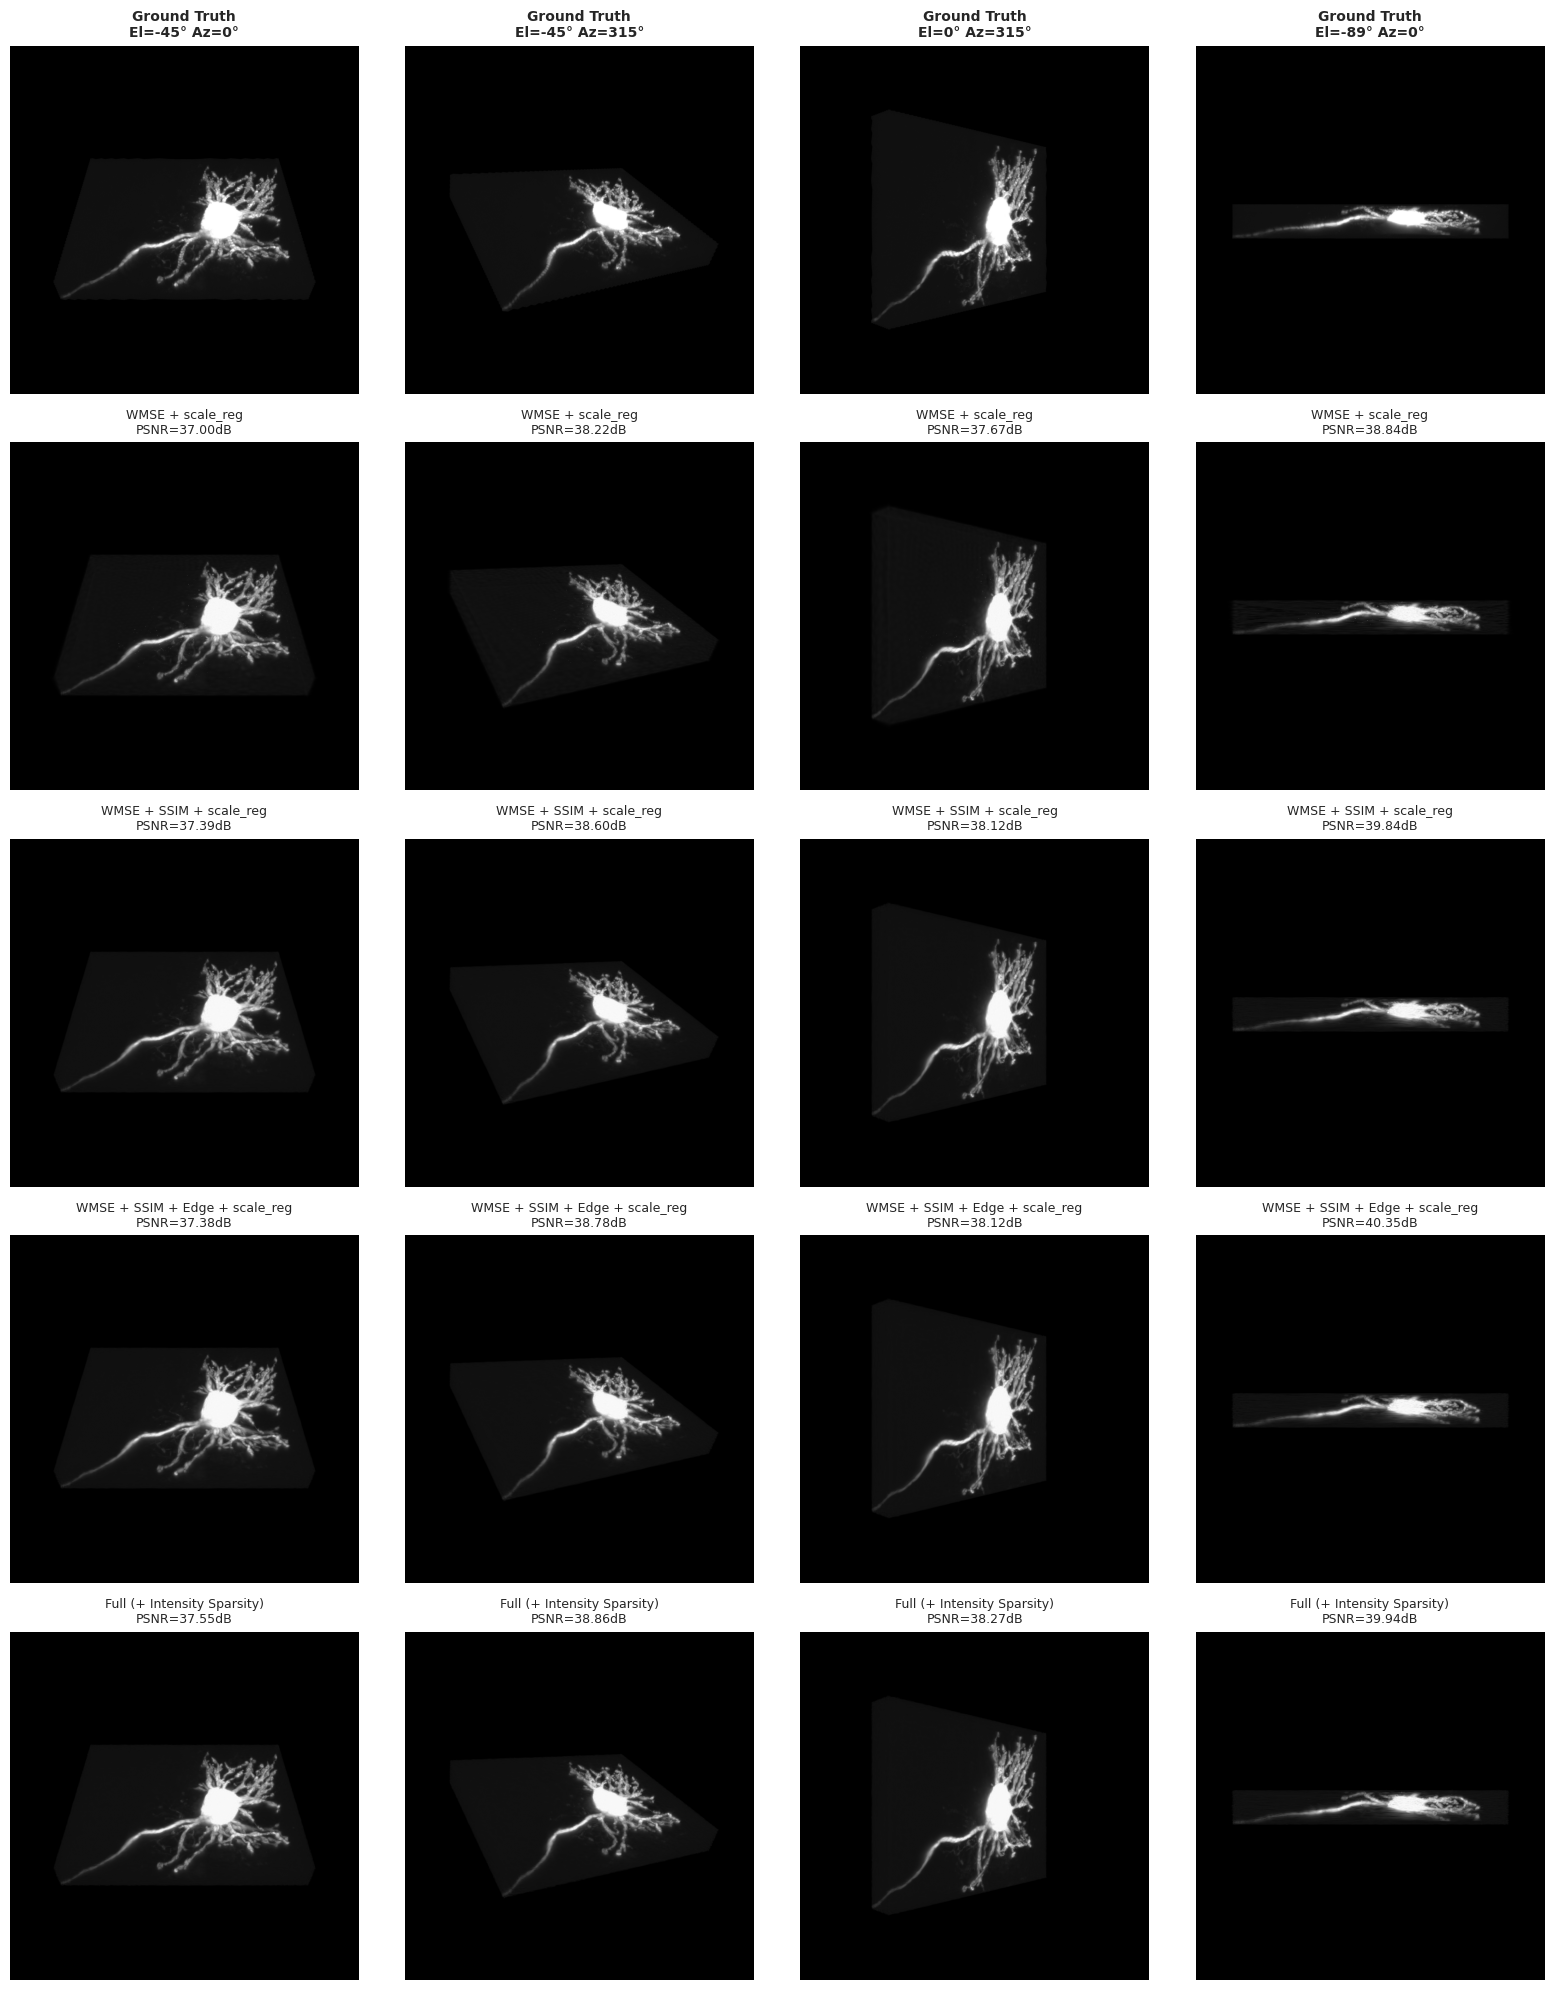

✓ Visual comparison saved to /workspace/hisnegs/experiments/ablation_visual_comparison.pdf


In [53]:
# Render sample views from each model for visual comparison
sample_indices = [0, len(test_poses)//4, len(test_poses)//2, -1]  # 4 diverse views
n_samples = len(sample_indices)

fig, axes = plt.subplots(len(MODELS) + 1, n_samples, figsize=(4*n_samples, 4*(len(MODELS)+1)))

with torch.no_grad():
    for col_idx, pose_idx in enumerate(sample_indices):
        pose = test_poses[pose_idx]
        R, T = pose['R'].to(device), pose['T'].to(device)
        
        # Render ground truth
        gt_mip = render_gt_mip(
            vol_gpu, camera, R, T,
            n_samples=256, near=0.5, far=6.0,
            aspect_scales=aspect_scales
        )
        
        axes[0, col_idx].imshow(gt_mip.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        axes[0, col_idx].set_title(f"Ground Truth\nEl={pose['elevation']:.0f}° Az={pose['azimuth']:.0f}°",
                                    fontsize=10, fontweight='bold')
        axes[0, col_idx].axis('off')
        
        # Render each model
        for row_idx, (name, gaussians) in enumerate(loaded_models.items(), start=1):
            gaussians_corrected = apply_aspect_correction(gaussians, aspect_scales)
            pred_mip, _ = render_mip_projection(
                gaussians_corrected, camera, R, T, beta=50.0, chunk_size=4096
            )
            
            # Compute PSNR for this view
            mse = F.mse_loss(pred_mip, gt_mip).item()
            psnr = -10.0 * np.log10(max(mse, 1e-12))
            
            axes[row_idx, col_idx].imshow(pred_mip.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
            axes[row_idx, col_idx].set_title(f"{MODELS[name]['label']}\nPSNR={psnr:.2f}dB",
                                             fontsize=9)
            axes[row_idx, col_idx].axis('off')

plt.tight_layout()
experiments_dir = Path('/workspace/hisnegs/experiments')
plt.savefig(experiments_dir / 'ablation_visual_comparison.png', dpi=200, bbox_inches='tight')
plt.savefig(experiments_dir / 'ablation_visual_comparison.pdf', bbox_inches='tight')
plt.show()

print(f"✓ Visual comparison saved to {experiments_dir / 'ablation_visual_comparison.pdf'}")

## Statistical Analysis: Pairwise Comparisons

In [54]:
from scipy import stats

# Perform pairwise t-tests for PSNR
print("\nPairwise T-Tests (PSNR)")
print("="*70)

model_names = list(MODELS.keys())
pairwise_results = []

for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        name1, name2 = model_names[i], model_names[j]
        psnr1 = evaluation_results[name1]['psnr'].values
        psnr2 = evaluation_results[name2]['psnr'].values
        
        t_stat, p_value = stats.ttest_rel(psnr1, psnr2)
        mean_diff = psnr1.mean() - psnr2.mean()
        
        significance = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns'))
        
        pairwise_results.append({
            'Model 1': MODELS[name1]['label'],
            'Model 2': MODELS[name2]['label'],
            'Δ PSNR': f"{mean_diff:+.3f}",
            't-stat': f"{t_stat:.3f}",
            'p-value': f"{p_value:.4f}",
            'Sig.': significance
        })
        
        print(f"{MODELS[name1]['label']:30s} vs {MODELS[name2]['label']:30s}")
        print(f"  Δ PSNR = {mean_diff:+.3f} dB, t={t_stat:.3f}, p={p_value:.4f} {significance}")

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df.to_csv(OUTPUT_DIR / 'pairwise_ttests.csv', index=False)

print("\n" + "="*70)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print(f"✓ Pairwise tests saved to {OUTPUT_DIR / 'pairwise_ttests.csv'}")


Pairwise T-Tests (PSNR)
WMSE + scale_reg               vs WMSE + SSIM + scale_reg       
  Δ PSNR = -0.558 dB, t=-8.781, p=0.0000 ***
WMSE + scale_reg               vs WMSE + SSIM + Edge + scale_reg
  Δ PSNR = -0.736 dB, t=-7.386, p=0.0000 ***
WMSE + scale_reg               vs Full (+ Intensity Sparsity)   
  Δ PSNR = -0.745 dB, t=-11.410, p=0.0000 ***
WMSE + SSIM + scale_reg        vs WMSE + SSIM + Edge + scale_reg
  Δ PSNR = -0.178 dB, t=-4.063, p=0.0003 ***
WMSE + SSIM + scale_reg        vs Full (+ Intensity Sparsity)   
  Δ PSNR = -0.187 dB, t=-10.598, p=0.0000 ***
WMSE + SSIM + Edge + scale_reg vs Full (+ Intensity Sparsity)   
  Δ PSNR = -0.009 dB, t=-0.244, p=0.8091 ns

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant
✓ Pairwise tests saved to /workspace/hisnegs/ablation_output/pairwise_ttests.csv


## Final Summary and Conclusions

In [55]:
print("\n" + "="*80)
print("ABLATION STUDY CONCLUSIONS")
print("="*80)

# Find best model for each metric
best_psnr = max([(name, evaluation_results[name]['psnr'].mean()) for name in MODELS.keys()], key=lambda x: x[1])
best_ssim = max([(name, evaluation_results[name]['ssim'].mean()) for name in MODELS.keys()], key=lambda x: x[1])
best_mae = min([(name, evaluation_results[name]['mae'].mean()) for name in MODELS.keys()], key=lambda x: x[1])

print(f"\nBest PSNR: {MODELS[best_psnr[0]]['label']} ({best_psnr[1]:.2f} dB)")
print(f"Best SSIM: {MODELS[best_ssim[0]]['label']} ({best_ssim[1]:.4f})")
print(f"Best MAE:  {MODELS[best_mae[0]]['label']} ({best_mae[1]:.5f})")

print("\nKey Findings:")
print("1. Loss Component Impact:")
baseline_psnr = evaluation_results['WMSE']['psnr'].mean()
full_psnr = evaluation_results['Full']['psnr'].mean()
improvement = full_psnr - baseline_psnr
print(f"   - Full model improves PSNR by {improvement:+.2f} dB over WMSE baseline")

print("\n2. Model Efficiency:")
for name in MODELS.keys():
    K = loaded_models[name].means.shape[0]
    psnr = evaluation_results[name]['psnr'].mean()
    print(f"   - {MODELS[name]['label']:30s}: {K:6,} Gaussians, PSNR={psnr:.2f} dB")

print("\n3. Output Files Generated:")
print(f"   - {OUTPUT_DIR / 'ablation_summary.csv'}")
print(f"   - {OUTPUT_DIR / 'training_curves_comparison.png'}")
print(f"   - {OUTPUT_DIR / 'metric_distributions.png'}")
print(f"   - {OUTPUT_DIR / 'efficiency_comparison.png'}")
print(f"   - {OUTPUT_DIR / 'visual_comparison.png'}")
print(f"   - {OUTPUT_DIR / 'pairwise_ttests.csv'}")

print("\n" + "="*80)
print("✓ ABLATION STUDY COMPLETE")
print("="*80)


ABLATION STUDY CONCLUSIONS

Best PSNR: Full (+ Intensity Sparsity) (38.15 dB)
Best SSIM: Full (+ Intensity Sparsity) (0.9875)
Best MAE:  Full (+ Intensity Sparsity) (0.00266)

Key Findings:
1. Loss Component Impact:
   - Full model improves PSNR by +0.75 dB over WMSE baseline

2. Model Efficiency:
   - WMSE + scale_reg              : 49,484 Gaussians, PSNR=37.41 dB
   - WMSE + SSIM + scale_reg       : 47,564 Gaussians, PSNR=37.97 dB
   - WMSE + SSIM + Edge + scale_reg: 47,564 Gaussians, PSNR=38.14 dB
   - Full (+ Intensity Sparsity)   : 41,471 Gaussians, PSNR=38.15 dB

3. Output Files Generated:
   - /workspace/hisnegs/ablation_output/ablation_summary.csv
   - /workspace/hisnegs/ablation_output/training_curves_comparison.png
   - /workspace/hisnegs/ablation_output/metric_distributions.png
   - /workspace/hisnegs/ablation_output/efficiency_comparison.png
   - /workspace/hisnegs/ablation_output/visual_comparison.png
   - /workspace/hisnegs/ablation_output/pairwise_ttests.csv

✓ ABLATION